In [25]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import re
import requests
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import mean_squared_error


In [26]:
with open('coffee_words.pickle','rb') as read_file:
    coffee = pickle.load(read_file)
with open('coffee_ratings.pickle','rb') as read_file:
    ratings = pickle.load(read_file)
with open('combined.pickle','rb') as read_file:
    combined = pickle.load(read_file)

In [13]:
combined.head()

,roaster,origin,roast_level,group,rating,aroma,body,flavor,aftertaste,acidity
0,Jackrabbit Java,Costa Rica,Medium-Light,1,93,9.0,9.0,9.0,8.0,8.0
1,Jackrabbit Java,"Nyamasheke District, Rwanda",Medium-Light,0,92,9.0,8.0,9.0,8.0,8.0
2,Red Rooster Coffee Roaster,"Los Naranjos, La Argentina, Huila Department, ...",Light,0,96,9.0,9.0,10.0,9.0,9.0
3,Paradise Roasters,"Huila, Colombia",Light,0,95,9.0,9.0,9.0,9.0,9.0
4,Kakalove Cafe,"Antioquia Department, Colombia",Medium-Light,1,95,9.0,9.0,9.0,9.0,9.0


In [20]:
combined.loc[(combined.aroma == 'NR')|(combined.aroma == 'NA'),'aroma'] = '-999'
combined.aroma = combined.aroma.astype(float)
combined.aroma = combined.aroma.round(0)

combined.loc[(combined.body == 'NR')|(combined.body == 'NA'),'body'] = '-999'
combined.body = combined.body.astype(float)
combined.body = combined.body.round(0)

combined.loc[(combined.flavor == 'NR')|(combined.flavor == 'NA'),'flavor'] = '-999'
combined.flavor = combined.flavor.astype(float)
combined.flavor = combined.flavor.round(0)

combined.aftertaste.fillna('-999',inplace=True)
combined.aftertaste = combined.aftertaste.astype(float)
combined.aftertaste = combined.aftertaste.round(0)

combined.loc[(combined.acidity == 'NR')|(combined.acidity == 'NA')|(combined.acidity == 'na')|(combined.acidity == 'n/a'),'acidity'] = '-999'
combined.loc[(combined.acidity == 'Very Low'),'acidity'] = '1'
combined.loc[(combined.acidity == 'Low'),'acidity'] = '3'
combined.loc[(combined.acidity == 'Moderate'),'acidity'] = '5'
combined.acidity.fillna(-999,inplace=True)
combined.acidity = combined.acidity.astype(float)
combined.acidity = combined.acidity.round(0)

combined.dropna(subset=['rating','aroma','body','flavor','aftertaste','acidity'],axis=0,inplace=True)
combined.head()

,roaster,origin,roast_level,group,rating,aroma,body,flavor,aftertaste,acidity
0,Jackrabbit Java,Costa Rica,Medium-Light,1,93,9.0,9.0,9.0,8.0,8.0
1,Jackrabbit Java,"Nyamasheke District, Rwanda",Medium-Light,0,92,9.0,8.0,9.0,8.0,8.0
2,Red Rooster Coffee Roaster,"Los Naranjos, La Argentina, Huila Department, ...",Light,0,96,9.0,9.0,10.0,9.0,9.0
3,Paradise Roasters,"Huila, Colombia",Light,0,95,9.0,9.0,9.0,9.0,9.0
4,Kakalove Cafe,"Antioquia Department, Colombia",Medium-Light,1,95,9.0,9.0,9.0,9.0,9.0


In [22]:
features = ['aroma','body','flavor','aftertaste','acidity','group']
useful = combined[(combined.rating>0)&(combined.aroma>0)&(combined.body>0)&(combined.flavor>0)&(combined.aftertaste>0)&(combined.acidity>0)]
_X, X_, _y, y_ = train_test_split(useful[features],useful.rating,test_size=.2,random_state=42)

In [28]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

In [37]:
train_X, train_y = np.array(_X), np.array(_y)
#run the CV
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s = [] #collect the validation results

for train_ind, val_ind in kf.split(train_X,train_y):
    
    tr_X, tr_y = train_X[train_ind], train_y[train_ind]
    X_val, y_val = train_X[val_ind], train_y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()

    lm.fit(_X, _y)
    cv_lm_r2s.append(round(lm.score(X_val, y_val), 3))

print('Simple regression scores: ', cv_lm_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}','\n')

test_set_pred = lm.predict(X_)

mae_kfoldlinear = mae(y_,test_set_pred)

print('The average error (MAE) on a predicted value on the holdout test data is: ',mae_kfoldlinear)

Simple regression scores:  [0.943, 0.934, 0.961, 0.944, 0.934] 

Simple mean cv r^2: 0.943 +- 0.010 

The average error (MAE) on a predicted value on the holdout test data is:  0.3655678275111266


In [36]:
list(zip(_X.columns, lm.coef_))

[('aroma', 1.0357180523615321),
 ('body', 0.761661190542472),
 ('flavor', 1.0150629408067047),
 ('aftertaste', 1.1496692980631293),
 ('acidity', 0.9055599342572095),
 ('group', 0.09993682914157594)]

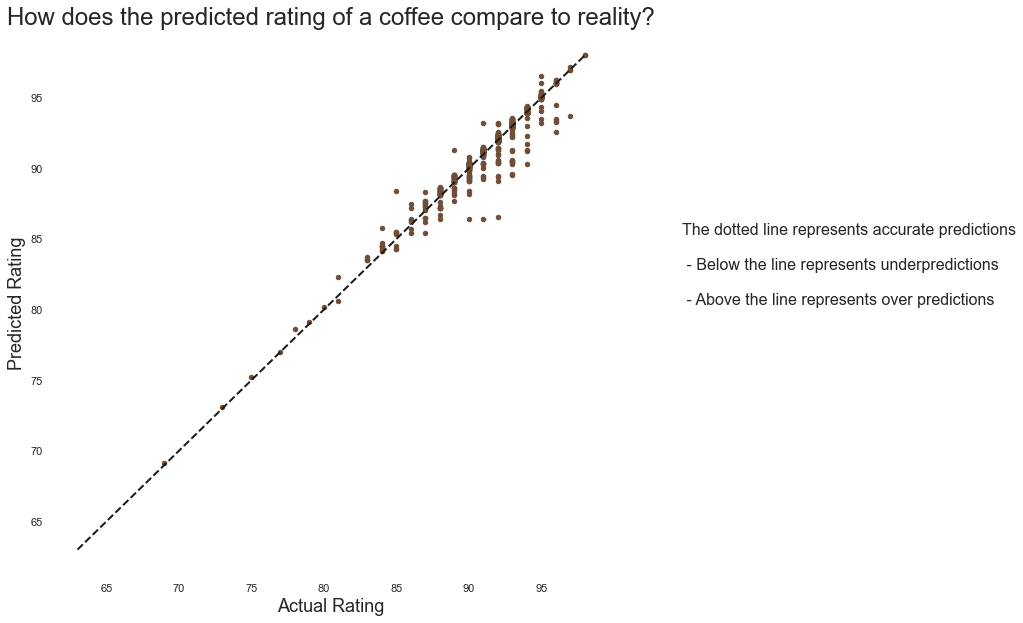

In [50]:
y = useful.rating
sns.set(rc={'figure.figsize':(10, 10)})
fig, ax = plt.subplots()
ax.scatter(y_, test_set_pred, s=20,color='#6f4e37')
ax.set_facecolor('white')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Actual Rating',fontsize=18)
ax.set_ylabel('Predicted Rating',fontsize=18)
ax.set_title('How does the predicted rating of a coffee compare to reality?',fontsize=24)
txt = 'The dotted line represents accurate predictions' + '\n \n'+' - Below the line represents underpredictions' + '\n\n'+ ' - Above the line represents over predictions'
text = fig.text(1,.5,txt,fontsize=16)
# fig.savefig('OneDrive\Desktop\Metis\Projects\Project 2\wridge_actualvspredicted',kind='png')
plt.show()